# 📚 Setup and Library Imports

In [143]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler, LabelBinarizer
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report,roc_curve,auc,precision_recall_curve
from sklearn.model_selection import learning_curve
from catboost import CatBoostClassifier
from itertools import cycle
import joblib
import warnings
warnings.filterwarnings('ignore')

In [144]:
df=pd.read_csv("/kaggle/input/air-quality-and-pollution-assessment/updated_pollution_dataset.csv")

# 🔍 Data Inspection and Summary

In [145]:
df.head(10)

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good
5,39.4,96.6,14.6,35.5,42.9,17.9,1.82,3.1,674,Hazardous
6,41.7,82.5,1.7,15.8,31.1,12.7,1.80,4.6,735,Poor
7,31.0,59.6,5.0,16.8,24.2,13.6,1.38,6.3,443,Moderate
8,29.4,93.8,10.3,22.7,45.1,11.8,2.03,5.4,486,Poor
9,33.2,80.5,11.1,24.4,32.0,15.3,1.69,4.9,535,Poor


In [146]:
df.shape

(5000, 10)

In [147]:
df.columns

Index(['Temperature', 'Humidity', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO',
       'Proximity_to_Industrial_Areas', 'Population_Density', 'Air Quality'],
      dtype='object')

In [148]:
df.isna().sum()

Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64

In [149]:
df.duplicated().sum()

0

# 📊 Exploratory Data Analysis (EDA)

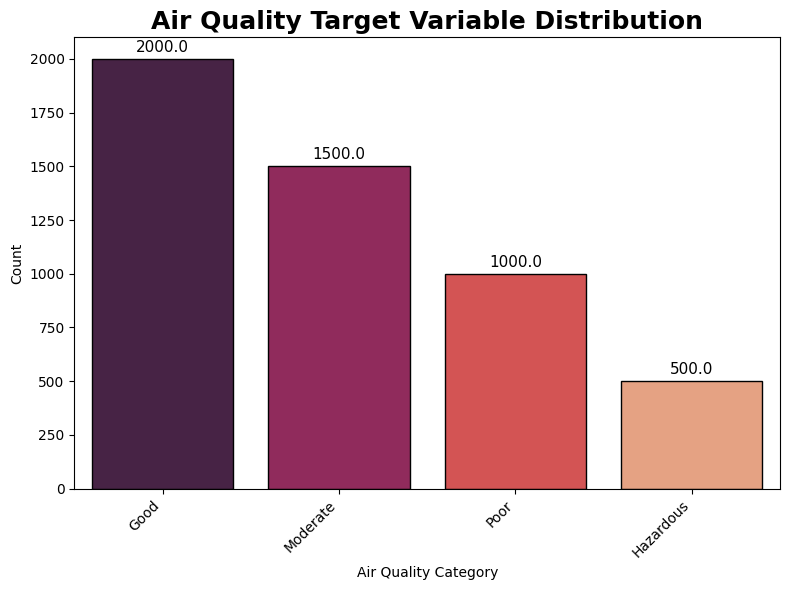

In [150]:
target_palette = sns.color_palette("rocket", n_colors=len(df['Air Quality'].unique()))

plt.figure(figsize=(8, 6))
ax = sns.countplot(
    data=df,
    x='Air Quality',
    order=df['Air Quality'].value_counts().index,
    palette=target_palette,
    edgecolor='black'
)

# Add counts on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Air Quality Target Variable Distribution', fontsize=18, weight='bold')
plt.xlabel('Air Quality Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

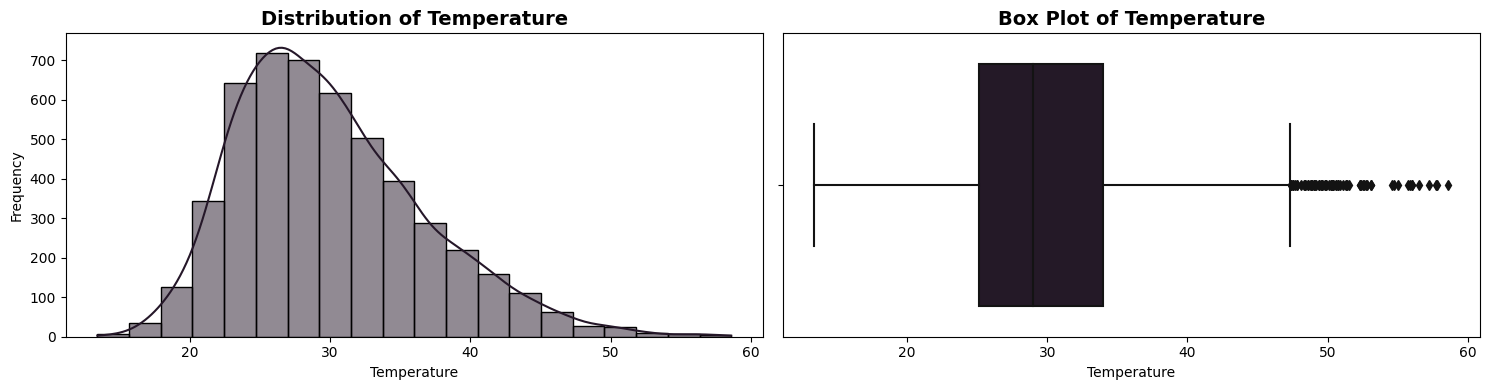

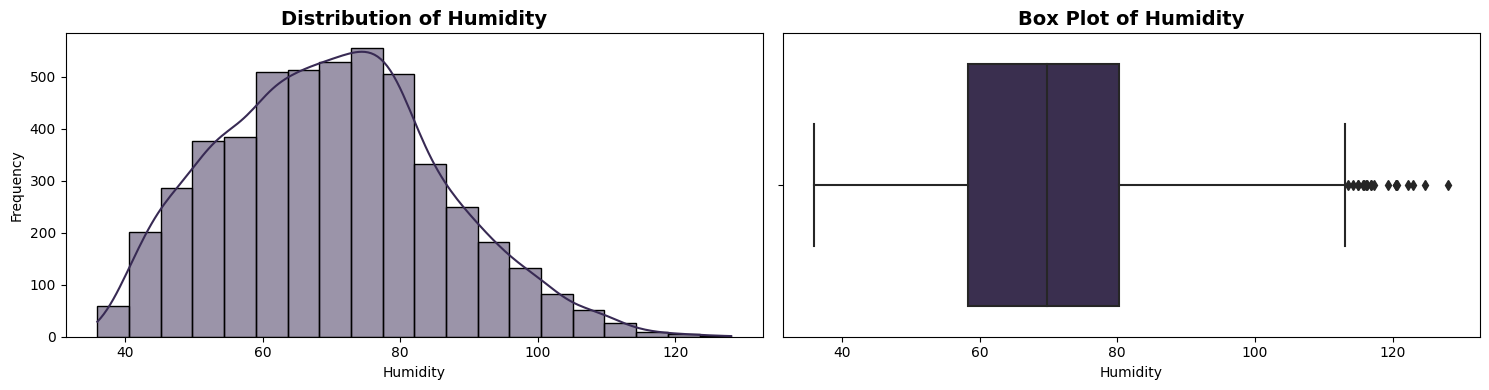

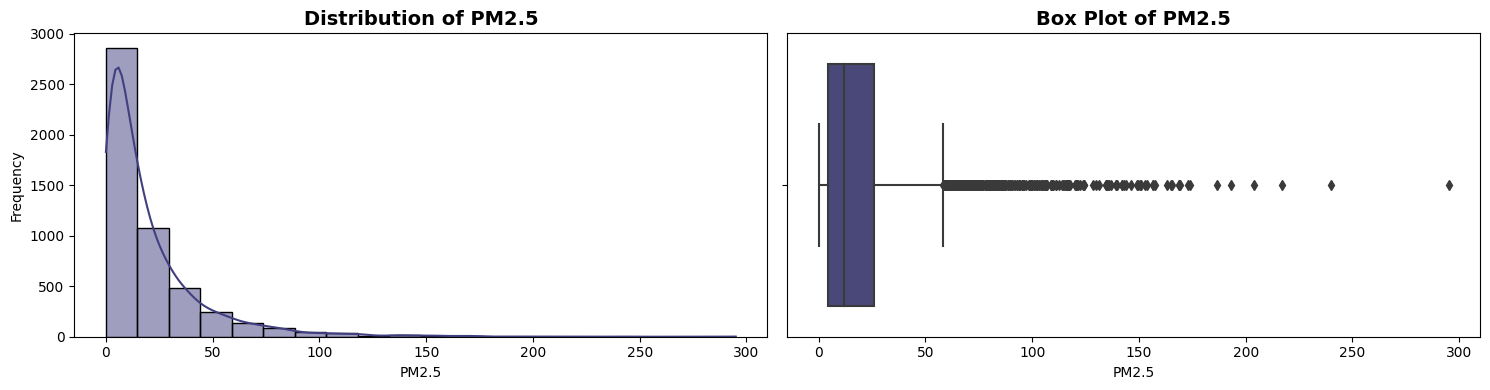

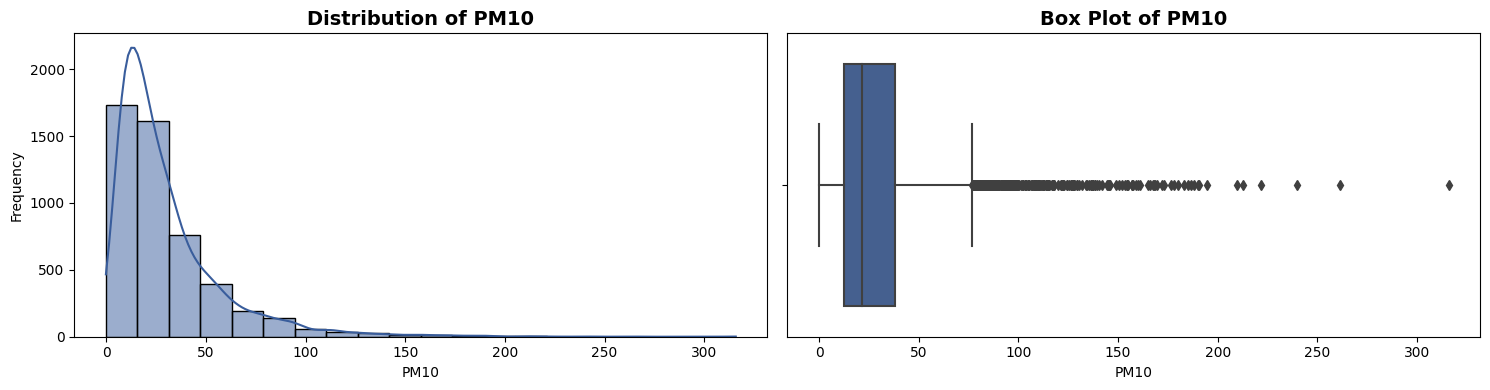

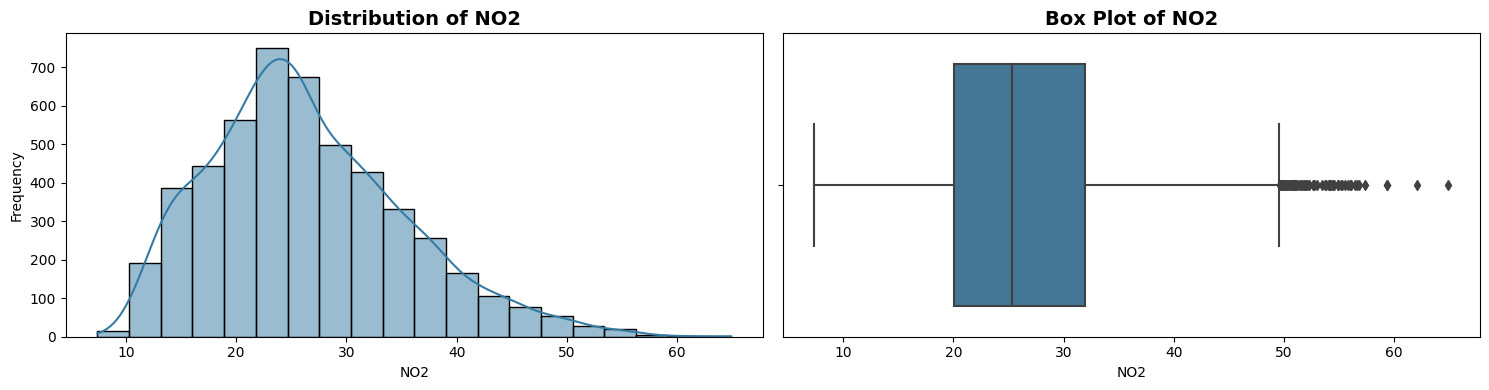

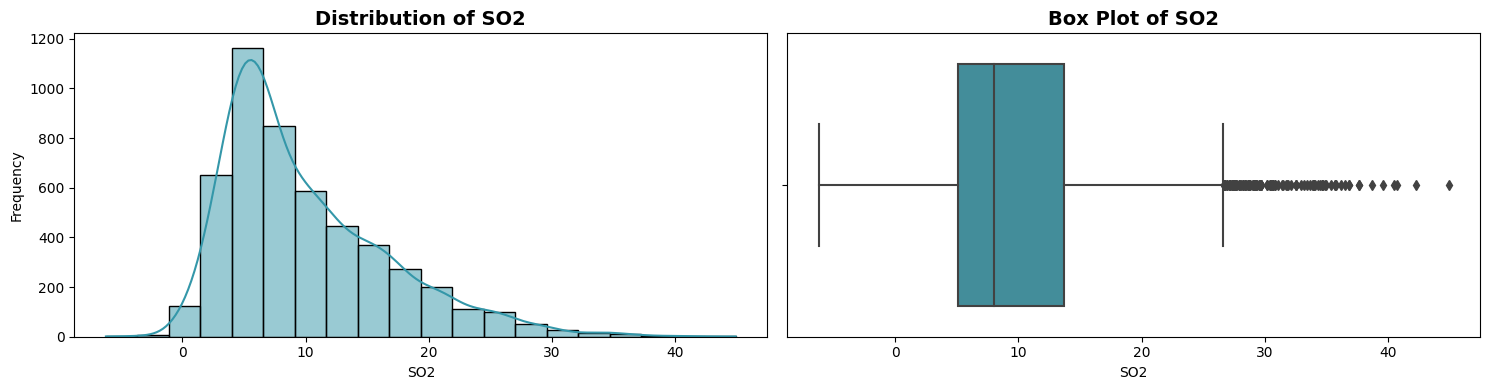

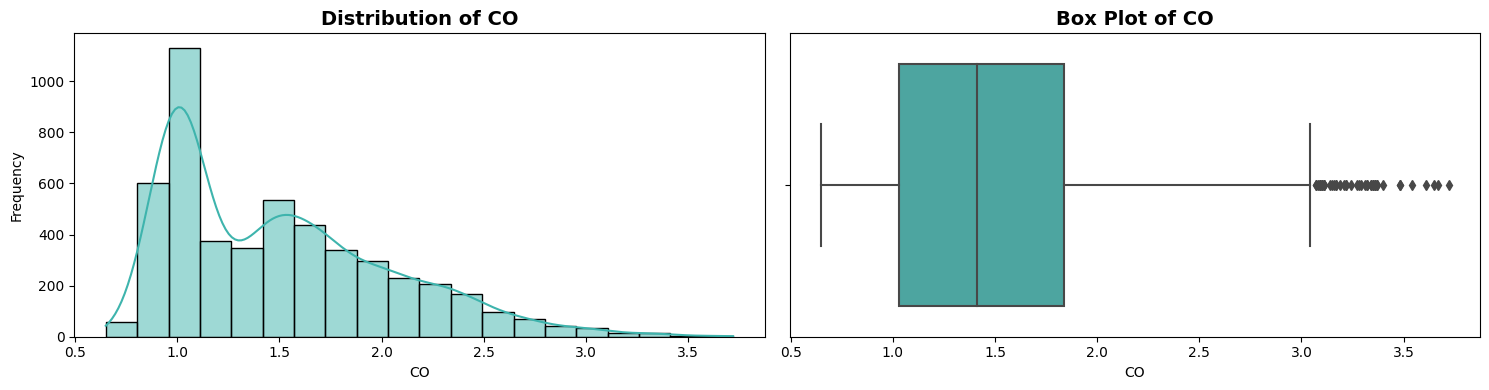

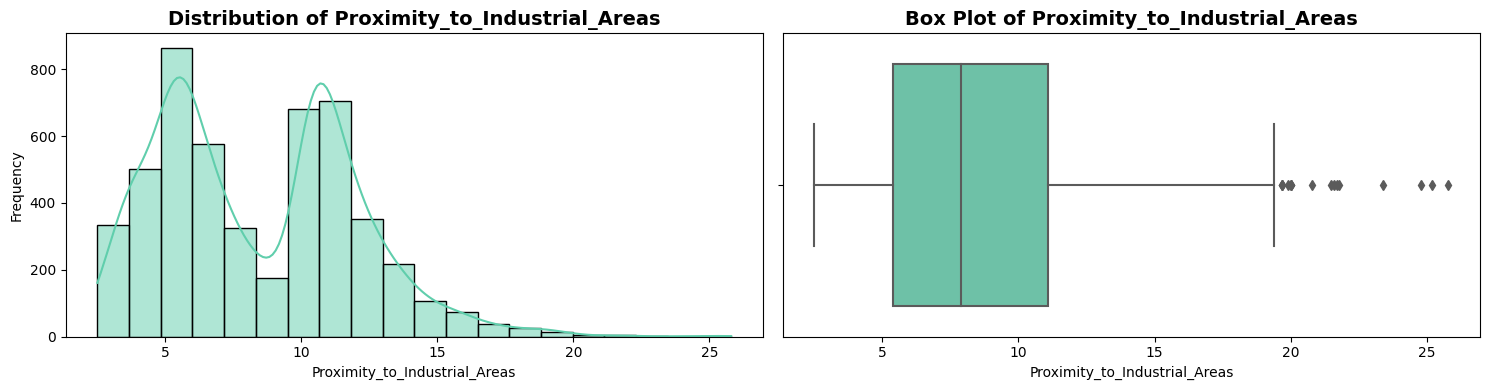

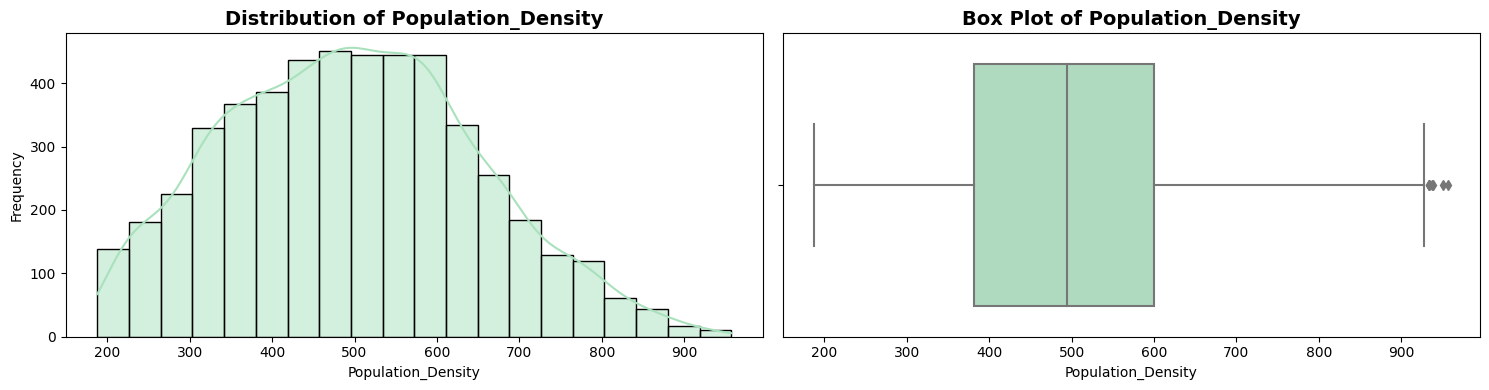

In [151]:
continuous_features = [
    'Temperature', 'Humidity', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO',
    'Proximity_to_Industrial_Areas', 'Population_Density'
]

palette = sns.color_palette("mako", len(continuous_features))

for i, col in enumerate(continuous_features):
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))

    # Histogram
    sns.histplot(df[col], kde=True, ax=axes[0], color=palette[i], bins=20, edgecolor='black')
    axes[0].set_title(f'Distribution of {col}', fontsize=14, weight='bold')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')

    # Box Plot
    sns.boxplot(x=df[col], ax=axes[1], color=palette[i])
    axes[1].set_title(f'Box Plot of {col}', fontsize=14, weight='bold')
    axes[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

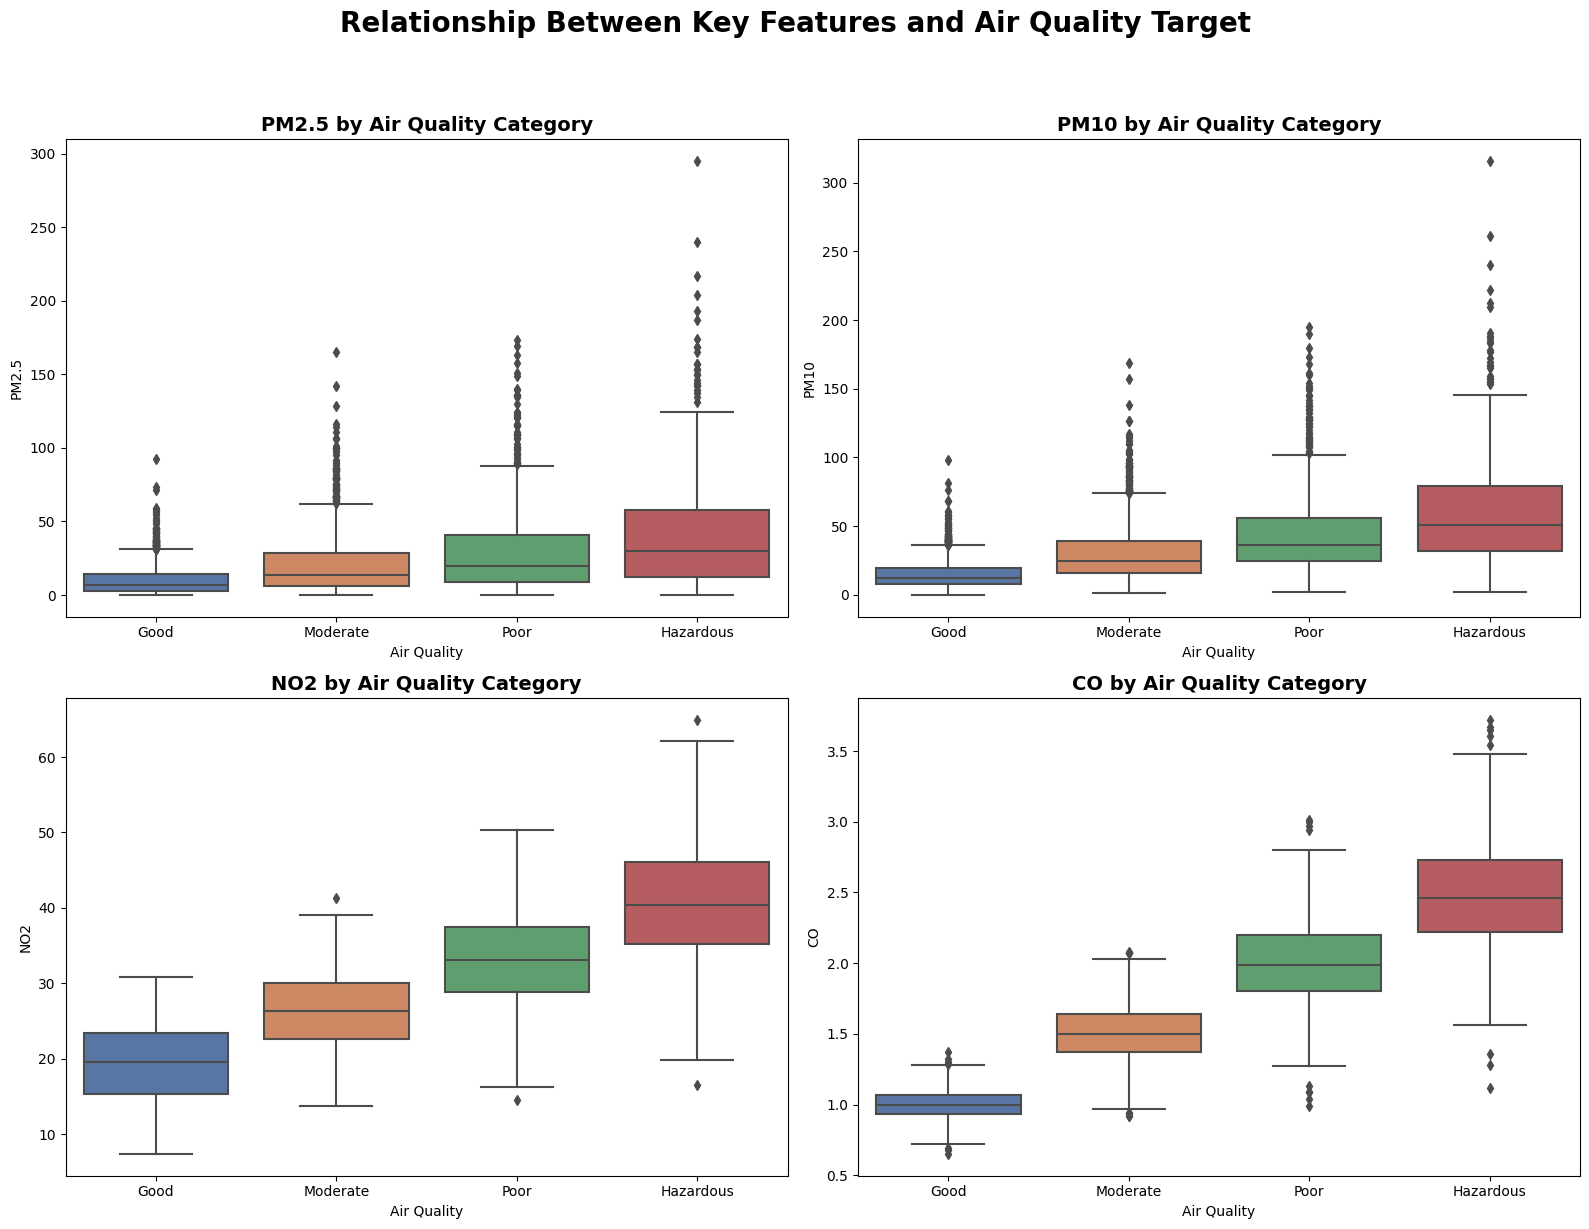

In [152]:
key_features = ['PM2.5', 'PM10', 'NO2', 'CO']

plt.figure(figsize=(16, 12))
rel_palette = 'deep'

for i, feature in enumerate(key_features):
    plt.subplot(2, 2, i + 1) 
    sns.boxplot(
        data=df,
        x='Air Quality',
        y=feature,
        order=['Good', 'Moderate', 'Poor', 'Hazardous'], 
        palette=rel_palette
    )
    plt.title(f'{feature} by Air Quality Category', fontsize=14, weight='bold')
    plt.xlabel('Air Quality')
    plt.ylabel(feature)
    plt.xticks(rotation=0)

plt.suptitle('Relationship Between Key Features and Air Quality Target', fontsize=20, weight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

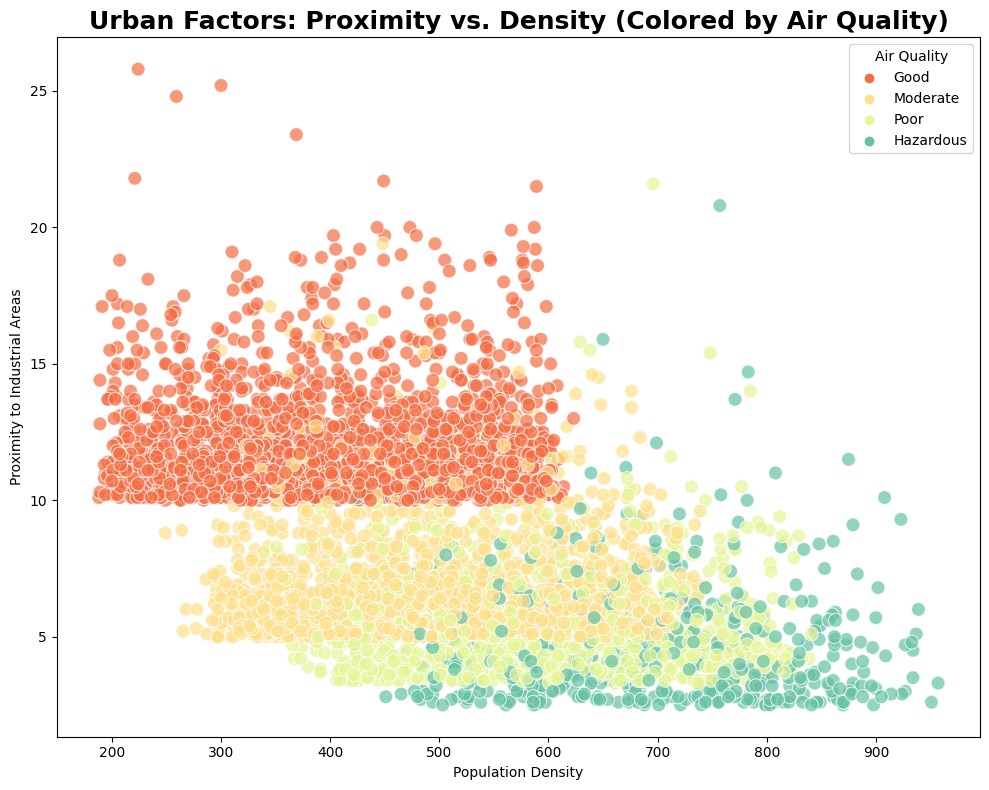

In [153]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=df,
    x='Population_Density',
    y='Proximity_to_Industrial_Areas',
    hue='Air Quality',
    hue_order=['Good', 'Moderate', 'Poor', 'Hazardous'],
    palette='Spectral',
    s=100,
    alpha=0.7,
    edgecolor='w'
)

plt.title('Urban Factors: Proximity vs. Density (Colored by Air Quality)', fontsize=18, weight='bold')
plt.xlabel('Population Density')
plt.ylabel('Proximity to Industrial Areas')
plt.legend(title='Air Quality')
plt.tight_layout()
plt.show()

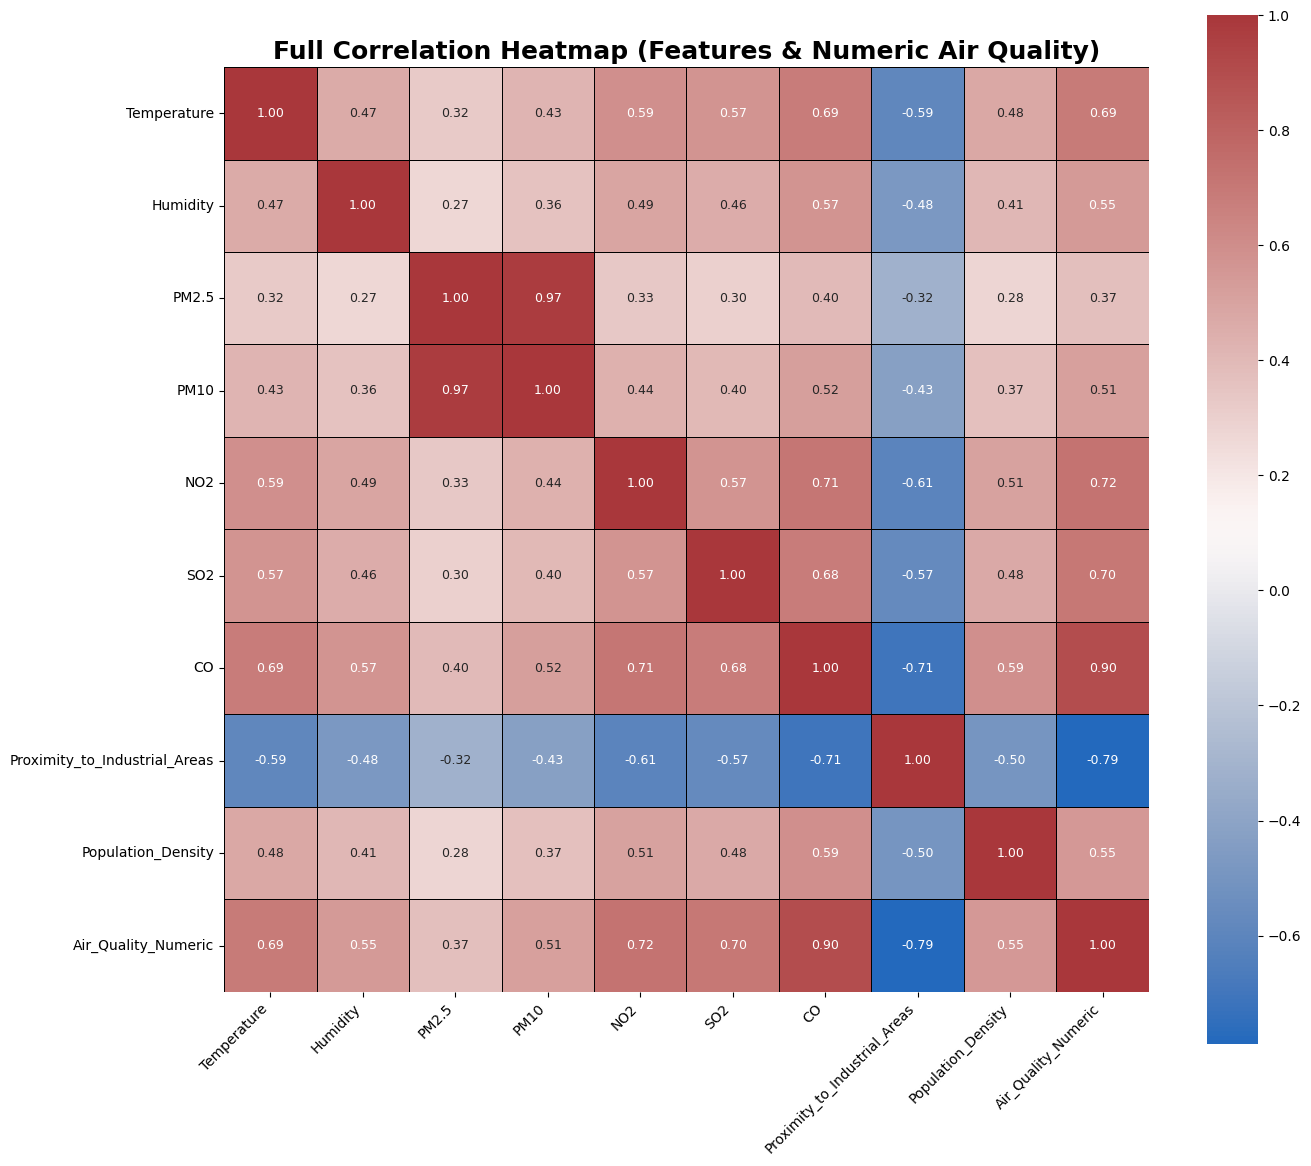

In [154]:
quality_mapping = {
    'Good': 1,
    'Moderate': 2,
    'Poor': 3,
    'Severe': 4
}

df['Air_Quality_Numeric'] = df['Air Quality'].map(quality_mapping)

all_features = [
    'Temperature', 'Humidity', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO',
    'Proximity_to_Industrial_Areas', 'Population_Density', 'Air_Quality_Numeric'
]

full_correlation_matrix = df[all_features].corr()

plt.figure(figsize=(14, 12))

sns.heatmap(
    full_correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='vlag',
    cbar=True,
    linewidths=.5,
    linecolor='black',
    square=True,
    annot_kws={'size': 9}
)

plt.title('Full Correlation Heatmap (Features & Numeric Air Quality)', fontsize=18, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

df.drop(columns=['Air_Quality_Numeric'], inplace=True)

# ✂️ Data Splitting (Train/Test)

In [155]:
X=df.drop(columns=["Air Quality"])

# Combine Hazardous and Poor together
y = df["Air Quality"].replace({
    "Hazardous": "Poor"
})

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=955,stratify=y)

# 🧹 Data Encoding & Scaling

In [156]:
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [157]:
scaler = RobustScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# 🧠 Model Building and Training

In [163]:
model = CatBoostClassifier(
    iterations=200,
    depth=10,
    learning_rate=0.2,
    l2_leaf_reg=3,
    border_count=128,
    bagging_temperature=2,
    random_strength=1,
    boosting_type='Plain',
    leaf_estimation_iterations=1,
    verbose=0,
    random_state=42
)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print("Testing accuracy:",accuracy_score(y_test, y_pred))

Testing accuracy: 0.99


# 📋 Confusion Matrix & Classification Report

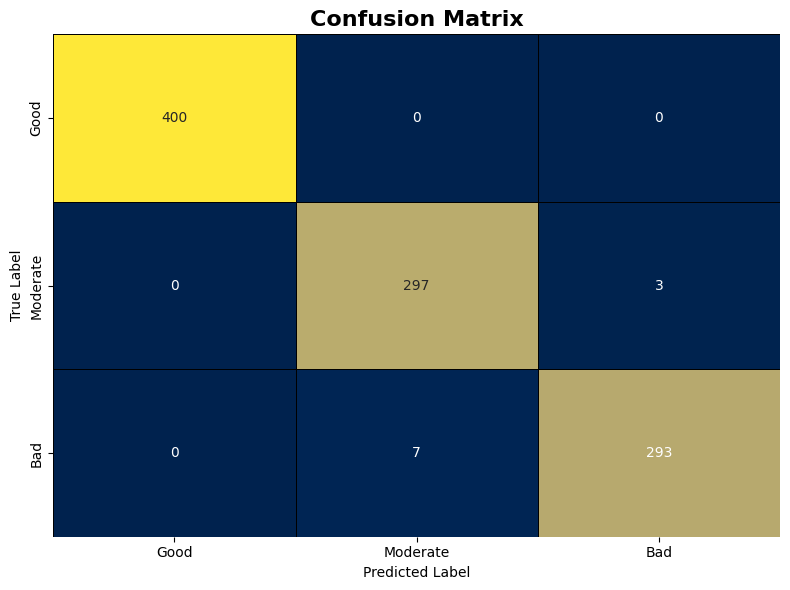


--- Classification Report ---
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00       400
    Moderate       0.98      0.99      0.98       300
         Bad       0.99      0.98      0.98       300

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [159]:
# # Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_names=["Good","Moderate","Bad"]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='cividis',
    linewidths=.5,
    linecolor='black',
    cbar=False,
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix', fontsize=16, weight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Print the classification report for detailed metrics
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=class_names))

# 🔮 Feature Importance

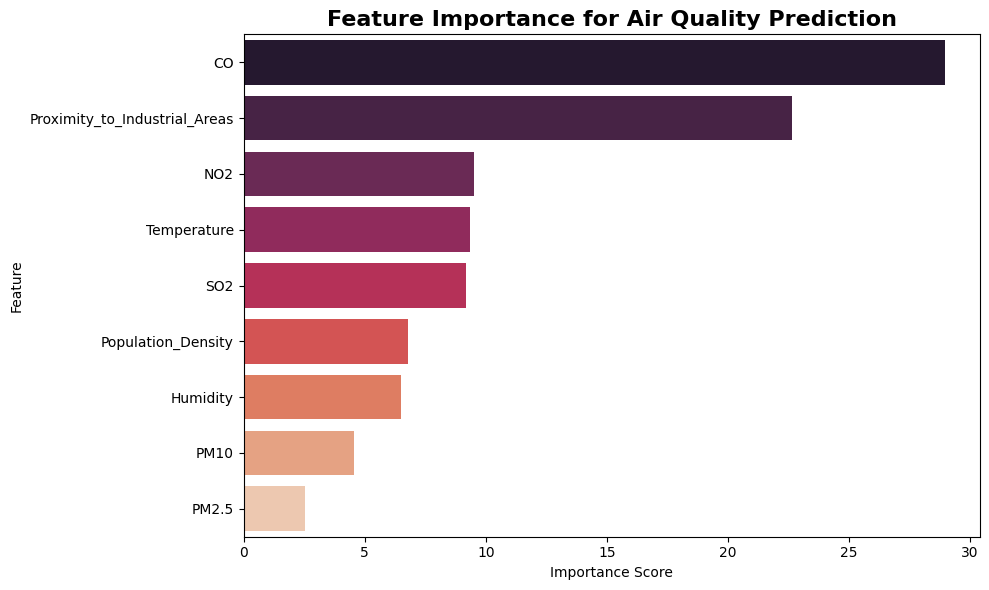

In [160]:
# Retrieve the feature names 
feature_names = X.columns 

feature_importances = pd.Series(
    model.feature_importances_,
    index=feature_names 
).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=feature_importances.values,
    y=feature_importances.index,
    palette='rocket'
)
plt.title('Feature Importance for Air Quality Prediction', fontsize=16, weight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 📈 ROC-AUC Curve Analysis

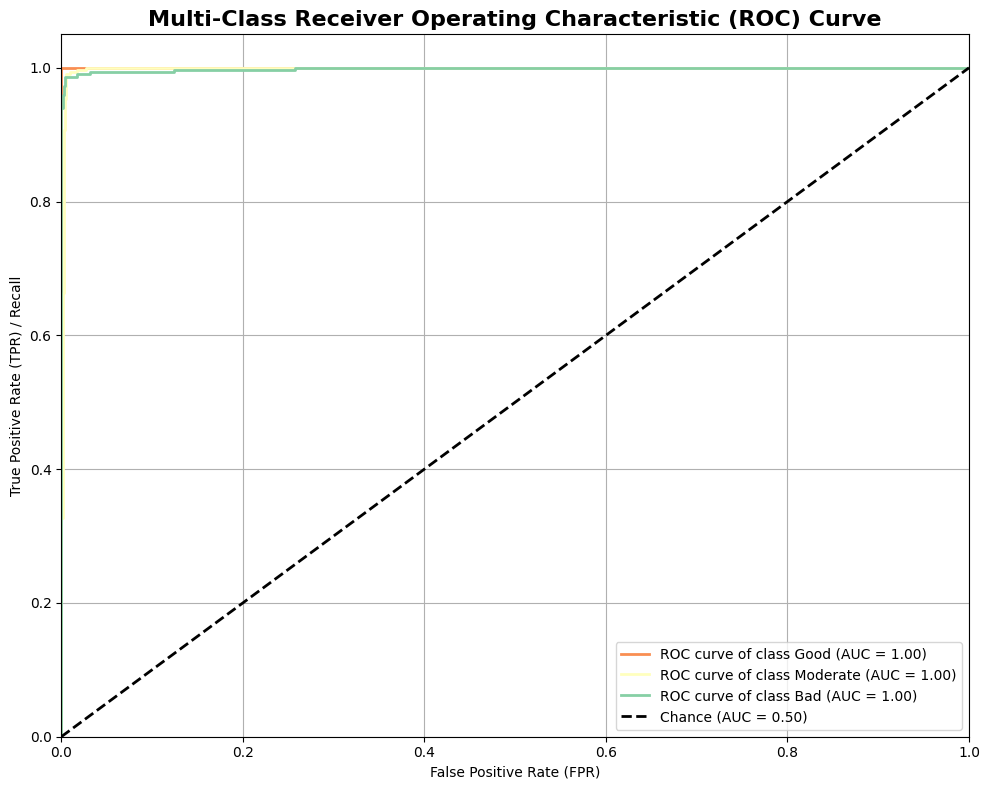

In [161]:
# Use LabelBinarizer to prepare the true labels for multi-class ROC (One-vs-Rest)
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)
n_classes = y_test_binarized.shape[1]
y_proba = model.predict_proba(x_test)

if y_proba.shape[1] != n_classes:
    print("Error: 'y_proba' (model prediction probabilities) is missing or incorrectly shaped. Cannot plot ROC.")
else:
    # 1. Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 2. Plotting all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(sns.color_palette("Spectral", n_classes))
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i], tpr[i], color=color, lw=2,
            label='ROC curve of class {0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i])
        )

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR) / Recall')
    plt.title('Multi-Class Receiver Operating Characteristic (ROC) Curve', fontsize=16, weight='bold')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 💾 Saving the Model 

In [162]:
joblib.dump(model, "AiroX.pkl")

['AiroX.pkl']